## Learn and interpret the patterns in interactions

In [421]:
import matplotlib.patches as mpatches
from sklearn import preprocessing 
from matplotlib.colors import from_levels_and_colors
from matplotlib import animation
from matplotlib.patches import Patch
from mat4py import loadmat
import itertools
import math

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklearn
import tensorflow as tf
import csv
import io
import sys
import pandas as pd

from datetime import datetime
from scipy.spatial import distance
from itertools import accumulate
from math import isclose
from enum import Enum

print('-- Sys version --', sys.version)

# My custom imports
import import_ipynb
import helper_functions

# Machine learning
from sklearn.cluster import MeanShift
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture #For GMM clustering


-- Sys version -- 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]


### Read labelled instances from .csv file

In [422]:
def convertArrayStringToFloatArray(arrayString):
    list = csv.DictReader(io.StringIO(arrayString))
    # returns: ['[33.42323129352791', ' 32.95392751557071', ... 
    
    stringsArray = []
    for index, string in enumerate(list.fieldnames):
        
        # All the values between first and last one have a " " space in front so we remove all the spaces
        adjustedString = string.strip()
        
        # First string contains this as a first character "[" so we remove the first character
        if (index == 0):
            adjustedString = adjustedString[1:]
        
        # Last string contains this as a last character "]" so we remove the last character from last value
        if (index == len(list.fieldnames)-1):
            adjustedString = adjustedString[:-1]
             
        stringsArray.append(adjustedString)
        
        #print('string -- adjustedString ',string, adjustedString)
        
    
    # Let's convert to np.array of floats
    np_valuesArray = np.asarray(stringsArray, dtype=np.float64).tolist() 
    
    # print(' ---- np_valuesArray ----- ', np_valuesArray)
    return np_valuesArray


In [423]:
# --- Consstants ---

INTERACTIONS_FILE_NAME = 'interactions_with_added_featuress_newest_labelled.csv'
#'interactions_labelled.csv'

CSV_CONVERTERS = {'Sec': convertArrayStringToFloatArray, 'Xcoord': convertArrayStringToFloatArray, 
                                                                 'Ycoord': convertArrayStringToFloatArray, 'DateTime': convertArrayStringToFloatArray,
                                                         'Speed': convertArrayStringToFloatArray, 'distanceFromConflictZone': convertArrayStringToFloatArray}

In [424]:
def readFromCsvFile():
    df = pd.read_csv(INTERACTIONS_FILE_NAME, sep=';', converters=CSV_CONVERTERS)
   
    return df


In [425]:
data = readFromCsvFile()
data.head()

,InteractionID,CarID,ID,DateTime,Sec,Xcoord,Ycoord,Speed,AgentType,timeOfEnteringInteractionZone,speedAtTheBorderOfInteractionZone,distanceFromConflictZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded
0,0,296,296,"[736942.6628986342, 736942.6629015394, 736942....","[1504540474.442, 1504540474.693, 1504540474.94...","[26.6613331938, 25.7778384119, 24.4089994135, ...","[-18.4036215072, -17.7473015992, -16.966888870...","[3.08102580335, 12.4167288091, 18.4838357672, ...",2,1.504540e+09,23.571225,"[35.9883654091085, 33.91341162440859, 31.92872...",21.370349,23.571225,12.371,1
1,0,296,12026,"[736942.6628481018, 736942.6628509606, 736942....","[1504540470.076, 1504540470.323, 1504540470.57...","[-18.0626008397, -17.649399756, -17.0124111051...","[-3.47456038593, -3.51120309955, -3.7310564605...","[8.5697905356, 6.14773525498, 8.17334896826, 9...",1,1.504540e+09,10.444818,"[17.323129463184166, 17.014202215783932, 16.67...",4.351052,10.444818,12.371,0
2,1,304,304,"[736942.6795602547, 736942.6795630787, 736942....","[1504541914.006, 1504541914.25, 1504541914.499...","[24.7684726474, 22.1011873829, 20.0061735875, ...","[-17.635534153, -15.6002859477, -13.5596313056...","[66.3198555486, 51.9756128556, 46.9436905719, ...",2,1.504542e+09,29.065146,"[33.44730370563436, 31.48207209081636, 29.6135...",23.003352,29.065146,-6.694,0
3,1,304,3904,"[736942.6796421065, 736942.6796450232, 736942....","[1504541921.078, 1504541921.33, 1504541921.574...","[12.43112122, 11.8120524922, 10.9918357403, 10...","[13.9206206091, 14.2792452515, 14.4436799512, ...","[10.358716824, 10.2803918697, 11.2492594945, 1...",1,1.504542e+09,11.647350,"[17.507198083899965, 17.30525816194477, 17.091...",5.765058,11.647350,-6.694,1
4,2,386,386,"[736942.6734056481, 736942.6734085301, 736942....","[1504541382.248, 1504541382.497, 1504541382.74...","[8.8422014458, 8.00413625362, 7.31329466607, 6...","[-4.49984287545, -3.96736392183, -3.6343632707...","[21.077369024, 12.2580601627, 11.0218610859, 1...",2,1.504541e+09,12.258060,"[11.732872339595428, 10.368595606192843, 9.163...",8.748449,18.210611,-2.574,0


## Add features to data

In [607]:
# ------ Get ATD for each bicycle separately ------

# Initially each instance has the ATD - but it is the ATD between the car and the first bicycle (in the interaction)
# But as some interactions have multiple bicycles we now calculate the ATD between each bicycle and car separately and
# set it to bicycles as "individualArrivalTimeDifference".
# (For the car and first bicyce that enters IZ the "individualArrivalTimeDifference" should be equal to "arrivalTimeDifference").
def findIndividualArrivalTimeDifferencePerAgent(row, df):
    DIGIT_TO_ROUND = 7
    
    interactionId = row['InteractionID']
    roundedArrivalTimeDiff = round(row['arrivalTimeDifference'], DIGIT_TO_ROUND)
    
    # Car
    if row['AgentType'] == 2:

        row['arrivalTimeDifference'] = roundedArrivalTimeDiff
        row['individualArrivalTimeDifference'] = roundedArrivalTimeDiff
     
    # Bicycle
    if row['AgentType'] == 1:
        
        vehicleDfRow = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]

        vehicleArrivalTime = vehicleDfRow['timeOfEnteringInteractionZone'].values[0]
        bicycleArrivalTime = row['timeOfEnteringInteractionZone']
        
        
        individualArrivalTimeDifference = vehicleArrivalTime - bicycleArrivalTime
        row['individualArrivalTimeDifference'] = round(individualArrivalTimeDifference, DIGIT_TO_ROUND)
        row['arrivalTimeDifference'] = roundedArrivalTimeDiff
        
        #print(' -------------------------------------individualArrivalTimeDifference----------------------------------- ', interactionId, individualArrivalTimeDifference)

    return row
    

def getDataWithIndividualArrivalTimeDifference(data):
    df = data.apply(lambda x: findIndividualArrivalTimeDifferencePerAgent(x, data), axis=1) 
    return df


In [719]:
def closest(lst, K): 
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 

def addDistanceFromCZOnceOtherAgentEneteredTheIZ(agent, df):
    interactionID = agent['InteractionID']
    vehicleEnteredIZFirst = agent['arrivalTimeDifference'] <= 0
    
    
    # Bicycle and vehicle entered IZ first
    if vehicleEnteredIZFirst == True and agent['AgentType'] == 1:
        #print(' ------- Bicycle ', interactionID)
        vehicle = df.loc[(df['InteractionID'] == interactionID) & (df['AgentType'] == 2)]

        timeOfVehicleEnteringIZ = vehicle['timeOfEnteringInteractionZone'].values[0]
        closestTsOfBicycleWhenVehicleEnteredIZ = closest(agent['Sec'], timeOfVehicleEnteringIZ)
        indexOfAgentTs = agent['Sec'].index(closestTsOfBicycleWhenVehicleEnteredIZ)
        bicycleDistanceFromCZWhenVehicleEneteredIZ = agent['distanceFromConflictZone'][indexOfAgentTs-1]
        agentsSpeedWhenVehicleEneteredIZ = agent['Speed'][indexOfAgentTs]

        agent['distanceFromCZWhenFirstAgentEnteredIZ'] = bicycleDistanceFromCZWhenVehicleEneteredIZ
        agent['speedWhenFirstAgentEnteredIZ'] = agentsSpeedWhenVehicleEneteredIZ



    # Vehicle and bicycle entered IZ first
    if vehicleEnteredIZFirst == False and agent['AgentType'] == 2:
        #print(' ------- Vehicle ', interactionID)
        bicycle = df.loc[(df['InteractionID'] == interactionID) & (df['AgentType'] == 1)]

        timeOfBicycleEnteringIZ = bicycle['timeOfEnteringInteractionZone'].values[0]
        closestTsOfAgentWhenBicycleEnteredIZ = closest(agent['Sec'], timeOfBicycleEnteringIZ)
        indexOfAgentTs = agent['Sec'].index(closestTsOfAgentWhenBicycleEnteredIZ)
        agentsDistanceFromCZWhenBicycleEneteredIZ = agent['distanceFromConflictZone'][indexOfAgentTs-1]
        agentsSpeedWhenBicycleEneteredIZ = agent['Speed'][indexOfAgentTs]

        agent['distanceFromCZWhenFirstAgentEnteredIZ'] = agentsDistanceFromCZWhenBicycleEneteredIZ
        agent['speedWhenFirstAgentEnteredIZ'] = agentsSpeedWhenBicycleEneteredIZ

    else:
        #print(' ------------- ', interactionID)

        timeOfAgentEnteringIZ = agent['timeOfEnteringInteractionZone']
        indexOfEnteringIZ = agent['Sec'].index(timeOfAgentEnteringIZ)
        distanceFromCZWhenEneteredIZ = agent['distanceFromConflictZone'][indexOfEnteringIZ]
        agentsSpeedWhenEneteredIZ = agent['Speed'][indexOfEnteringIZ]
        
        agent['distanceFromCZWhenFirstAgentEnteredIZ'] = distanceFromCZWhenEneteredIZ
        agent['speedWhenFirstAgentEnteredIZ'] = agentsSpeedWhenEneteredIZ

    return agent


def getDataWithDistanceFromCZOnceOtherAgentEneteredTheIZ(data):
    df = data.apply(lambda x: addDistanceFromCZOnceOtherAgentEneteredTheIZ(x, data), axis=1) 
    return df


In [720]:
def removeBicyclesWithLabelDifferentFromFirst(row, df):
        
    interactionId = row['InteractionID']
    
    # Vehicle
    if row['AgentType'] == 2:
        return row
    
    # Bicycle
    if row['AgentType'] == 1:
        
        vehicleDfRow = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 2)]
        bicycleDfRows = df.loc[(df['InteractionID'] == interactionId) & (df['AgentType'] == 1)]

        yieldedValuesBicycles =  bicycleDfRows['yielded'].values
        yieldedValueVehicle =  vehicleDfRow['yielded'].values[0]
        
        
        # If all bicycles in this interaction have the same label then all is good
        if all(y == yieldedValuesBicycles[0] for y in yieldedValuesBicycles):
            return row
        
        # But if they don't then we keep this bicycle row only if this is the correct one and has opposite label than the vehicle
        if row['yielded'] != yieldedValueVehicle:
            return row

        #print(' -------------- delete bicycle row -----------------', interactionId)
        return None

    return row


In [721]:
def getDataWithAddedFeatures():
    data = readFromCsvFile()
    df_1 = getDataWithIndividualArrivalTimeDifference(data) 
    df_2 = getDataWithDistanceFromCZOnceOtherAgentEneteredTheIZ(df_1) 
    return df_2


# Let's remove bicycles that should be interactions by themselves so the ones that differ from the first 
# bicycle that car interacted with.
def getDataWithoutInvalidBicyclesAndWithAddedFeatures():
    data = getDataWithAddedFeatures()
    df = data.apply(lambda x: removeBicyclesWithLabelDifferentFromFirst(x, data), axis=1)
    return df



In [722]:
#dataWithIndividualArrivalTimeDiff = getDataWithIndividualArrivalTimeDifference()
#dataWithIndividualArrivalTimeDiff.head()


In [723]:
validInteractionsWithAddedDataDf = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
validInteractionsWithAddedDataDf.head()

#validInteractionsWithAddedDataDf.loc[(validInteractionsWithAddedDataDf['InteractionID'] == 52)].head()

#dataWithIndividualArrivalTimeDifference.to_csv('valid_interactions_with_added_data.csv')

,InteractionID,CarID,ID,DateTime,Sec,Xcoord,Ycoord,Speed,AgentType,timeOfEnteringInteractionZone,speedAtTheBorderOfInteractionZone,distanceFromConflictZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded,individualArrivalTimeDifference,distanceFromCZWhenFirstAgentEnteredIZ,speedWhenFirstAgentEnteredIZ
0,0.0,296.0,296.0,"[736942.6628986342, 736942.6629015394, 736942....","[1504540474.442, 1504540474.693, 1504540474.94...","[26.6613331938, 25.7778384119, 24.4089994135, ...","[-18.4036215072, -17.7473015992, -16.966888870...","[3.08102580335, 12.4167288091, 18.4838357672, ...",2.0,1.504540e+09,23.571225,"[35.9883654091085, 33.91341162440859, 31.92872...",21.370349,23.571225,12.371,1.0,12.371,40.112275,3.081026
1,0.0,296.0,12026.0,"[736942.6628481018, 736942.6628509606, 736942....","[1504540470.076, 1504540470.323, 1504540470.57...","[-18.0626008397, -17.649399756, -17.0124111051...","[-3.47456038593, -3.51120309955, -3.7310564605...","[8.5697905356, 6.14773525498, 8.17334896826, 9...",1.0,1.504540e+09,10.444818,"[17.323129463184166, 17.014202215783932, 16.67...",4.351052,10.444818,12.371,0.0,12.371,12.132890,10.444818
2,1.0,304.0,304.0,"[736942.6795602547, 736942.6795630787, 736942....","[1504541914.006, 1504541914.25, 1504541914.499...","[24.7684726474, 22.1011873829, 20.0061735875, ...","[-17.635534153, -15.6002859477, -13.5596313056...","[66.3198555486, 51.9756128556, 46.9436905719, ...",2.0,1.504542e+09,29.065146,"[33.44730370563436, 31.48207209081636, 29.6135...",23.003352,29.065146,-6.694,0.0,-6.694,12.107704,29.065146
3,1.0,304.0,3904.0,"[736942.6796421065, 736942.6796450232, 736942....","[1504541921.078, 1504541921.33, 1504541921.574...","[12.43112122, 11.8120524922, 10.9918357403, 10...","[13.9206206091, 14.2792452515, 14.4436799512, ...","[10.358716824, 10.2803918697, 11.2492594945, 1...",1.0,1.504542e+09,11.647350,"[17.507198083899965, 17.30525816194477, 17.091...",5.765058,11.647350,-6.694,1.0,-6.694,15.744698,11.647350
4,2.0,386.0,386.0,"[736942.6734056481, 736942.6734085301, 736942....","[1504541382.248, 1504541382.497, 1504541382.74...","[8.8422014458, 8.00413625362, 7.31329466607, 6...","[-4.49984287545, -3.96736392183, -3.6343632707...","[21.077369024, 12.2580601627, 11.0218610859, 1...",2.0,1.504541e+09,12.258060,"[11.732872339595428, 10.368595606192843, 9.163...",8.748449,18.210611,-2.574,0.0,-2.574,10.368596,12.258060


In [724]:
# ------ Vehicle & Bicycle ------

def getBycicleEvents():
    data = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    return data.loc[data['AgentType'] == 1]

def getVehicleEvents():
    data = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    return data.loc[data['AgentType'] == 2]

# ------ General Conflict & Non-conflict ------

def getConflictEvents():
    data = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    
    # Basically we only take into account vehicle and first bicycle event
    df = data.loc[(data['arrivalTimeDifference'] == data['individualArrivalTimeDifference']) & (abs(data['individualArrivalTimeDifference']) <= 5.5)]
    
    uniqueConflictInteractions = df.drop_duplicates(subset=['InteractionID', 'AgentType'], keep="first")
    # uniqueConflictInteractions.to_csv('conflict_events_unique.csv')
    return uniqueConflictInteractions
    
def getNonConflictEvents():    
    data = getDataWithoutInvalidBicyclesAndWithAddedFeatures()
    
    # Basically we only take into account vehicle and first bicycle event
    df = data.loc[(data['arrivalTimeDifference'] == data['individualArrivalTimeDifference']) & (abs(data['individualArrivalTimeDifference']) > 5.5)]
    
    # For interaction 242 for example there are 2 bicycles with same exact ts for entering the IZ so we just want to keep one of them
    uniqueNonConflictInteractions = df.drop_duplicates(subset=['InteractionID', 'AgentType'], keep="first")
    #uniqueNonConflictInteractions.to_csv('non-conflict_events_unique.csv')
    return uniqueNonConflictInteractions

# ------ Non-Conflict ------

def getNonConflictBycicleEvent():
    nonConflictEvents = getNonConflictEvents()
    return nonConflictEvents.loc[nonConflictEvents['AgentType'] == 1]

def getNonConflictVehicleEvent():
    nonConflictEvents = getNonConflictEvents()
    return nonConflictEvents.loc[nonConflictEvents['AgentType'] == 2]

# ------ Conflict ------

def getConflictBycicleEvent():
    conflictEvents = getConflictEvents()
    return conflictEvents.loc[conflictEvents['AgentType'] == 1]

def getConflictVehicleEvent():
    conflictEvents = getConflictEvents()
    return conflictEvents.loc[conflictEvents['AgentType'] == 2]

# ------ Yield ------
# Car yielded

def getYieldBycicleEvent():
    conflictBicycleEvents = getConflictBycicleEvent()
    return conflictBicycleEvents.loc[conflictBicycleEvents['yielded'] == 0]

def getYieldVehicleEvent():
    conflictVehicleEvents = getConflictVehicleEvent()
    return conflictVehicleEvents.loc[conflictVehicleEvents['yielded'] == 1]


# ------ Non-yield ------
# Car did not yield

def getNonYieldBycicleEvent():
    conflictBicycleEvents = getConflictBycicleEvent()
    return conflictBicycleEvents.loc[conflictBicycleEvents['yielded'] == 1]

def getNonYieldVehicleEvent():
    conflictVehicleEvents = getConflictVehicleEvent()
    return conflictVehicleEvents.loc[conflictVehicleEvents['yielded'] == 0]



# ------ Number of conflict events ------

def getNumberOfConflictEvent():
    conflictEvents = getConflictEvents()
    uniqueConflictInteractions = conflictEvents.drop_duplicates(subset=['InteractionID'], keep="first")
    return len(uniqueConflictInteractions)

def getNumberOfNonConflictEvent():
    nonConflictEvents = getNonConflictEvents()
    uniqueNonConflictInteractions = nonConflictEvents.drop_duplicates(subset=['InteractionID'], keep="first")
    return len(uniqueNonConflictInteractions)



#### Conflict Events

In [713]:
conflictEvents = getConflictEvents()
conflictEvents.head()

,InteractionID,CarID,ID,DateTime,Sec,Xcoord,Ycoord,Speed,AgentType,timeOfEnteringInteractionZone,speedAtTheBorderOfInteractionZone,distanceFromConflictZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded,individualArrivalTimeDifference,distanceFromCZWhenFirstAgentEnteredIZ
4,2.0,386.0,386.0,"[736942.6734056481, 736942.6734085301, 736942....","[1504541382.248, 1504541382.497, 1504541382.74...","[8.8422014458, 8.00413625362, 7.31329466607, 6...","[-4.49984287545, -3.96736392183, -3.6343632707...","[21.077369024, 12.2580601627, 11.0218610859, 1...",2.0,1.504541e+09,12.258060,"[11.732872339595428, 10.368595606192843, 9.163...",8.748449,18.210611,-2.574,0.0,-2.574,10.368596
5,2.0,386.0,644.0,"[736942.6733953588, 736942.6733981828, 736942....","[1504541381.359, 1504541381.603, 1504541381.85...","[20.124126488, 19.5865386634, 19.0124895931, 1...","[10.8222273594, 11.3463343216, 11.9126782081, ...","[19.6880308986, 13.3273012137, 12.0910469062, ...",1.0,1.504541e+09,16.039216,"[29.881271832727236, 29.65422884038087, 29.546...",7.891338,16.039216,-2.574,1.0,-2.574,22.175599
6,6.0,903.0,903.0,"[736942.6832251505, 736942.6832280208, 736942....","[1504542230.653, 1504542230.901, 1504542231.14...","[24.1775879048, 21.8263768629, 20.1585866405, ...","[-14.8464213674, -13.0150248519, -11.933643396...","[52.8459296606, 44.0182142809, 35.36225136, 32...",2.0,1.504542e+09,11.315749,"[33.52256660431523, 32.31042440211384, 31.1757...",9.059500,12.359894,5.324,1.0,5.324,7.951856
7,6.0,903.0,8154.0,"[736942.6831916436, 736942.6831945486, 736942....","[1504542227.758, 1504542228.009, 1504542228.25...","[-15.3783394275, -14.8660339562, -14.172866438...","[-5.33181520605, -5.33195641711, -5.5994239463...","[8.99059762109, 7.9933313106, 9.2680085026, 9....",1.0,1.504542e+09,10.313321,"[13.634709321429177, 12.997855643425492, 12.43...",8.803138,12.779806,5.324,0.0,5.324,11.215112
8,9.0,1344.0,1344.0,"[736942.8319400348, 736942.8319429051, 736942....","[1504555079.619, 1504555079.867, 1504555080.11...","[25.6260070565, 24.9922313861, 23.6358076902, ...","[-18.28393764, -16.5691649171, -15.2969796712,...","[29.0974229328, 27.1052809538, 26.4848187585, ...",2.0,1.504555e+09,28.661613,"[35.71195064274886, 33.95197658077097, 32.5109...",0.444279,28.661613,1.381,1.0,1.381,29.903858


In [714]:
uniqueConflictInteractions = getNumberOfConflictEvent()
print('Number of conflict events: ', uniqueConflictInteractions)


Number of conflict events:  97


#### Non-conflict Events

In [621]:
nonConflictEvents = getNonConflictEvents()
nonConflictEvents.head()


,InteractionID,CarID,ID,DateTime,Sec,Xcoord,Ycoord,Speed,AgentType,timeOfEnteringInteractionZone,speedAtTheBorderOfInteractionZone,distanceFromConflictZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded,individualArrivalTimeDifference,distanceFromCZWhenFirstAgentEnteredIZ
0,0.0,296.0,296.0,"[736942.6628986342, 736942.6629015394, 736942....","[1504540474.442, 1504540474.693, 1504540474.94...","[26.6613331938, 25.7778384119, 24.4089994135, ...","[-18.4036215072, -17.7473015992, -16.966888870...","[3.08102580335, 12.4167288091, 18.4838357672, ...",2.0,1.504540e+09,23.571225,"[35.9883654091085, 33.91341162440859, 31.92872...",21.370349,23.571225,12.371,1.0,12.371,40.112275
1,0.0,296.0,12026.0,"[736942.6628481018, 736942.6628509606, 736942....","[1504540470.076, 1504540470.323, 1504540470.57...","[-18.0626008397, -17.649399756, -17.0124111051...","[-3.47456038593, -3.51120309955, -3.7310564605...","[8.5697905356, 6.14773525498, 8.17334896826, 9...",1.0,1.504540e+09,10.444818,"[17.323129463184166, 17.014202215783932, 16.67...",4.351052,10.444818,12.371,0.0,12.371,12.132890
2,1.0,304.0,304.0,"[736942.6795602547, 736942.6795630787, 736942....","[1504541914.006, 1504541914.25, 1504541914.499...","[24.7684726474, 22.1011873829, 20.0061735875, ...","[-17.635534153, -15.6002859477, -13.5596313056...","[66.3198555486, 51.9756128556, 46.9436905719, ...",2.0,1.504542e+09,29.065146,"[33.44730370563436, 31.48207209081636, 29.6135...",23.003352,29.065146,-6.694,0.0,-6.694,12.107704
3,1.0,304.0,3904.0,"[736942.6796421065, 736942.6796450232, 736942....","[1504541921.078, 1504541921.33, 1504541921.574...","[12.43112122, 11.8120524922, 10.9918357403, 10...","[13.9206206091, 14.2792452515, 14.4436799512, ...","[10.358716824, 10.2803918697, 11.2492594945, 1...",1.0,1.504542e+09,11.647350,"[17.507198083899965, 17.30525816194477, 17.091...",5.765058,11.647350,-6.694,1.0,-6.694,15.744698
23,29.0,4569.0,4569.0,"[736942.6736448264, 736942.6736476389, 736942....","[1504541402.913, 1504541403.156, 1504541403.40...","[21.3988556286, 20.1131470158, 18.9746437379, ...","[-13.0500781108, -12.2913194229, -11.568593764...","[23.4732865754, 22.7520973129, 21.6952646898, ...",2.0,1.504541e+09,1.369400,"[29.873385039250806, 28.30540812679563, 26.665...",1.369400,14.820684,6.763,1.0,6.763,33.692561


In [622]:
uniqueNonConflictInteractions = getNumberOfNonConflictEvent()

print('Number of non-conflict events: ', uniqueNonConflictInteractions)

Number of non-conflict events:  56


#### Vehicle Yielded Events

In [623]:
yieldVehicleEvent = getYieldVehicleEvent()
yieldVehicleEvent.head()

,InteractionID,CarID,ID,DateTime,Sec,Xcoord,Ycoord,Speed,AgentType,timeOfEnteringInteractionZone,speedAtTheBorderOfInteractionZone,distanceFromConflictZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded,individualArrivalTimeDifference,distanceFromCZWhenFirstAgentEnteredIZ
6,6.0,903.0,903.0,"[736942.6832251505, 736942.6832280208, 736942....","[1504542230.653, 1504542230.901, 1504542231.14...","[24.1775879048, 21.8263768629, 20.1585866405, ...","[-14.8464213674, -13.0150248519, -11.933643396...","[52.8459296606, 44.0182142809, 35.36225136, 32...",2.0,1.504542e+09,11.315749,"[33.52256660431523, 32.31042440211384, 31.1757...",9.059500,12.359894,5.324,1.0,5.324,7.951856
8,9.0,1344.0,1344.0,"[736942.8319400348, 736942.8319429051, 736942....","[1504555079.619, 1504555079.867, 1504555080.11...","[25.6260070565, 24.9922313861, 23.6358076902, ...","[-18.28393764, -16.5691649171, -15.2969796712,...","[29.0974229328, 27.1052809538, 26.4848187585, ...",2.0,1.504555e+09,28.661613,"[35.71195064274886, 33.95197658077097, 32.5109...",0.444279,28.661613,1.381,1.0,1.381,29.903858
10,10.0,1500.0,1500.0,"[736942.6736003356, 736942.6736031712, 736942....","[1504541399.069, 1504541399.314, 1504541399.56...","[25.3740063744, 24.8301306264, 23.197740221, 2...","[-17.4332519185, -16.611904675, -15.1328327615...","[17.6959992024, 13.5757401085, 24.5542428743, ...",2.0,1.504541e+09,1.720756,"[35.06018970229846, 33.724749895573034, 32.548...",1.499517,19.146624,3.993,1.0,3.993,28.713431
17,21.0,3211.0,3211.0,"[736942.7318623032, 736942.731865162, 736942.7...","[1504546432.903, 1504546433.15, 1504546433.398...","[25.0275093873, 23.3205200388, 21.6617435771, ...","[-17.0437310459, -15.0861305816, -13.171225772...","[51.0862849747, 42.4360433996, 39.257018221, 3...",2.0,1.504546e+09,2.536660,"[34.2605309971038, 32.79985519045853, 31.57752...",1.899142,15.508272,3.951,1.0,3.951,28.107799
43,52.0,9080.0,9080.0,"[736942.6739659491, 736942.6739688194, 736942....","[1504541430.658, 1504541430.906, 1504541431.15...","[-15.080824963, -14.7370331992, -14.1661470041...","[10.9658114246, 10.8173193189, 10.232635338, 9...","[3.85614935165, 5.31326400424, 8.17391917568, ...",2.0,1.504541e+09,11.264015,"[16.170219618885945, 5.524189509461763, 5.2285...",2.640923,16.286549,-0.585,1.0,-0.585,4.703047


In [624]:
print('Number of yield events: ', len(yieldVehicleEvent))


Number of yield events:  39


#### Vehicle Non-yielded Events

In [625]:
nonYieldVehicleEvent = getNonYieldVehicleEvent()
nonYieldVehicleEvent.head()

,InteractionID,CarID,ID,DateTime,Sec,Xcoord,Ycoord,Speed,AgentType,timeOfEnteringInteractionZone,speedAtTheBorderOfInteractionZone,distanceFromConflictZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded,individualArrivalTimeDifference,distanceFromCZWhenFirstAgentEnteredIZ
4,2.0,386.0,386.0,"[736942.6734056481, 736942.6734085301, 736942....","[1504541382.248, 1504541382.497, 1504541382.74...","[8.8422014458, 8.00413625362, 7.31329466607, 6...","[-4.49984287545, -3.96736392183, -3.6343632707...","[21.077369024, 12.2580601627, 11.0218610859, 1...",2.0,1.504541e+09,12.258060,"[11.732872339595428, 10.368595606192843, 9.163...",8.748449,18.210611,-2.574,0.0,-2.574,10.368596
12,14.0,2015.0,2015.0,"[736942.7294253588, 736942.7294282292, 736942....","[1504546222.351, 1504546222.599, 1504546222.84...","[8.678948549, 7.99955344643, 7.78571951615, 7....","[-4.97490729662, -4.67695176426, -4.4891404683...","[11.9199531555, 11.0190146622, 7.48843606685, ...",2.0,1.504546e+09,7.011014,"[11.190750677321525, 9.406593749587056, 7.8610...",6.882341,20.596770,-4.113,0.0,-4.113,6.512529
14,17.0,2893.0,2893.0,"[736942.7771895023, 736942.7771923727, 736942....","[1504550349.173, 1504550349.421, 1504550349.66...","[-13.4064141493, -11.5362017024, -9.8119487115...","[8.62455174701, 7.74215842307, 6.90033490046, ...","[28.0488985733, 28.0488985733, 28.0488985733, ...",2.0,1.504550e+09,28.048899,"[10.636878527821269, 7.882711074806535, 5.0833...",18.099168,28.048899,-1.484,0.0,-1.484,10.636879
19,23.0,3508.0,3508.0,"[736942.6670404051, 736942.6670432176, 736942....","[1504540832.291, 1504540832.534, 1504540832.78...","[23.87205628, 22.2387293746, 20.5134002347, 18...","[-16.8546235367, -15.2982375841, -13.129081876...","[58.5451640231, 41.5660876343, 40.3483725328, ...",2.0,1.504541e+09,21.193966,"[32.87993876740708, 31.286682041751693, 29.784...",14.244527,21.193966,-2.109,0.0,-2.109,12.750005
21,28.0,4289.0,4289.0,"[736942.729379537, 736942.7293824421, 736942.7...","[1504546218.392, 1504546218.643, 1504546218.88...","[25.2075226684, 25.1574634909, 23.6401334048, ...","[-17.5115559752, -17.3139719305, -15.750441556...","[32.5171472306, 8.87803628061, 22.8164419531, ...",2.0,1.504546e+09,14.667961,"[35.10775650937469, 33.59196957738339, 15.9631...",14.667961,20.084722,-2.524,0.0,-2.524,0.070794


In [626]:
print('Number of non-yield events: ', len(nonYieldVehicleEvent))

Number of non-yield events:  58


## Mean speed & Standard Deviation
* Of each vehicle and each bicycle
* Of all vehicles and of all bicycles

#### Let's find mean speed of each agent (both vehicles and bicycles)

In [627]:
def addMeanSpeedPerInstance(df):
    df['MeanSpeed'] = df['Speed'].apply(lambda x: sum(x)/len(x)) 
    return df

def getMeanSpeedForAllInstances(dataWithMeanSpeed):
    dfMeanSpeed = dataWithMeanSpeed["MeanSpeed"].mean()
    return dfMeanSpeed

# Find standard deviation of mean speeds
def getStandardDeviationForAllInstances(dataWithStandardDeviation):
    dfStandardDeviation = dataWithStandardDeviation["MeanSpeed"].std()
    return dfStandardDeviation


##### Bicycle mean speed

In [628]:
bicycleEvents = getBycicleEvents()
bicycleEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleEvents)
bicycleEventsWithMeanSpeed.head()

,InteractionID,CarID,ID,DateTime,Sec,Xcoord,Ycoord,Speed,AgentType,timeOfEnteringInteractionZone,speedAtTheBorderOfInteractionZone,distanceFromConflictZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded,individualArrivalTimeDifference,distanceFromCZWhenFirstAgentEnteredIZ,MeanSpeed
1,0.0,296.0,12026.0,"[736942.6628481018, 736942.6628509606, 736942....","[1504540470.076, 1504540470.323, 1504540470.57...","[-18.0626008397, -17.649399756, -17.0124111051...","[-3.47456038593, -3.51120309955, -3.7310564605...","[8.5697905356, 6.14773525498, 8.17334896826, 9...",1.0,1.504540e+09,10.444818,"[17.323129463184166, 17.014202215783932, 16.67...",4.351052,10.444818,12.371,0.0,12.371,12.132890,9.333535
3,1.0,304.0,3904.0,"[736942.6796421065, 736942.6796450232, 736942....","[1504541921.078, 1504541921.33, 1504541921.574...","[12.43112122, 11.8120524922, 10.9918357403, 10...","[13.9206206091, 14.2792452515, 14.4436799512, ...","[10.358716824, 10.2803918697, 11.2492594945, 1...",1.0,1.504542e+09,11.647350,"[17.507198083899965, 17.30525816194477, 17.091...",5.765058,11.647350,-6.694,1.0,-6.694,15.744698,7.586025
5,2.0,386.0,644.0,"[736942.6733953588, 736942.6733981828, 736942....","[1504541381.359, 1504541381.603, 1504541381.85...","[20.124126488, 19.5865386634, 19.0124895931, 1...","[10.8222273594, 11.3463343216, 11.9126782081, ...","[19.6880308986, 13.3273012137, 12.0910469062, ...",1.0,1.504541e+09,16.039216,"[29.881271832727236, 29.65422884038087, 29.546...",7.891338,16.039216,-2.574,1.0,-2.574,22.175599,12.023719
7,6.0,903.0,8154.0,"[736942.6831916436, 736942.6831945486, 736942....","[1504542227.758, 1504542228.009, 1504542228.25...","[-15.3783394275, -14.8660339562, -14.172866438...","[-5.33181520605, -5.33195641711, -5.5994239463...","[8.99059762109, 7.9933313106, 9.2680085026, 9....",1.0,1.504542e+09,10.313321,"[13.634709321429177, 12.997855643425492, 12.43...",8.803138,12.779806,5.324,0.0,5.324,11.215112,12.649029
9,9.0,1344.0,483.0,"[736942.8318925, 736942.8318953587, 736942.831...","[1504555075.512, 1504555075.759, 1504555076.00...","[21.4633364649, 20.133127237, 19.5516768177, 1...","[9.69031162166, 9.64910787339, 9.8939248828, 1...","[11.8964399434, 15.7270671556, 12.9543644446, ...",1.0,1.504555e+09,10.348475,"[31.747401800403036, 31.03318203819747, 30.291...",10.348352,12.245772,1.381,0.0,1.381,12.609661,10.879777


In [629]:
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle mean speed: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)


Bycicle mean speed:  12.768104704606166
Bycicle speed standard deviation:  3.790547672991757


##### Vehicle mean speed

In [630]:
vehicleEvents = getVehicleEvents()
vehicleEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleEvents)
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle mean speed: ', vehicleMeanSpeed)


vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)

Vehicle mean speed:  20.616296943170862
Vehicle speed standard deviation:  6.49222866809589


##### Non-conflict mean speed

In [631]:
# --- Bicycle ----
bicycleEvents = getNonConflictBycicleEvent()
bicycleEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleEvents)
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle non-conflict events mean speed: ', bicycleMeanSpeed)


bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)
print('\n')

# --- Vehicle ----
vehicleEvents = getNonConflictVehicleEvent()
vehicleEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleEvents)
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle non-conflict events mean speed: ', vehicleMeanSpeed)


vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)


Bycicle non-conflict events mean speed:  11.779597736173733
Bycicle speed standard deviation:  3.4911820627011676


Vehicle non-conflict events mean speed:  20.84947014539299
Vehicle speed standard deviation:  5.890276480846228


##### Conflict mean speed

In [632]:
# --- Bicycle ----
bicycleEvents = getConflictBycicleEvent()
bicycleEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleEvents)
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle conflict events mean speed: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)
print('\n')

# --- Vehicle ----
vehicleEvents = getConflictVehicleEvent()
vehicleEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleEvents)
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle conflict events mean speed: ', vehicleMeanSpeed)

vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)


Bycicle conflict events mean speed:  13.587234186670518
Bycicle speed standard deviation:  4.030243662621234


Vehicle conflict events mean speed:  20.481681486217884
Vehicle speed standard deviation:  6.841666096818086


##### Yield mean speed

In [633]:
# --- Bicycle ----
bicycleEvents = getYieldBycicleEvent()
bicycleEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleEvents)
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle mean speed when car yielded: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)
print('\n')

# --- Vehicle ----
vehicleEvents = getYieldVehicleEvent()
vehicleEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleEvents)
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle yield events mean speed: ', vehicleMeanSpeed)

vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)


Bycicle mean speed when car yielded:  14.654799971343474
Bycicle speed standard deviation:  4.4111896590150685


Vehicle yield events mean speed:  14.610492575869513
Vehicle speed standard deviation:  4.222914872816233


##### Non-yield mean speed

In [634]:
# --- Bicycle ----
bicycleEvents = getNonYieldBycicleEvent()
bicycleEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleEvents)
bicycleMeanSpeed = getMeanSpeedForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle mean speed when car did not yield: ', bicycleMeanSpeed)

bicycleSpeedStandardDeviation = getStandardDeviationForAllInstances(bicycleEventsWithMeanSpeed)
print('Bycicle speed standard deviation: ', bicycleSpeedStandardDeviation)
print('\n')

# --- Vehicle ----
vehicleEvents = getNonYieldVehicleEvent()
vehicleEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleEvents)
vehicleMeanSpeed = getMeanSpeedForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle non-yield events mean speed: ', vehicleMeanSpeed)

vehicleSpeedStandardDeviation = getStandardDeviationForAllInstances(vehicleEventsWithMeanSpeed)
print('Vehicle speed standard deviation: ', vehicleSpeedStandardDeviation)


Bycicle mean speed when car did not yield:  12.869388228011115
Bycicle speed standard deviation:  3.6166103814821846


Vehicle non-yield events mean speed:  24.42954989145213
Vehicle speed standard deviation:  5.244244064077654


## Speed At The Border Of Interaction Zone


In [635]:
def getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(data):
    df = data["speedAtTheBorderOfInteractionZone"].mean()
    return df


##### Bicycle Speed At The Border Of Interaction Zone

In [636]:
bicycleEvents = getBycicleEvents()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


Bycicle mean speed at the border of interaction zone:  12.2816442553374


##### Vehicle Speed At The Border Of Interaction Zone

In [637]:
vehicleEvents = getVehicleEvents()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)


Vehicle mean speed at the border of interaction zone:  20.93144829856896


##### Non-conflict Speed At The Border Of Interaction Zone

In [638]:
bicycleEvents = getNonConflictBycicleEvent()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle non-conflict event mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


vehicleEvents = getNonConflictVehicleEvent()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle non-conflict event mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)


Bycicle non-conflict event mean speed at the border of interaction zone:  11.204375003156429
Vehicle non-conflict event mean speed at the border of interaction zone:  22.72509134090645


##### Conflict Speed At The Border Of Interaction Zone

In [639]:
bicycleEvents = getConflictBycicleEvent()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle conflict events mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


vehicleEvents = getConflictVehicleEvent()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle conflict event mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)


Bycicle conflict events mean speed at the border of interaction zone:  13.203733380945556
Vehicle conflict event mean speed at the border of interaction zone:  19.895943037013296


##### Yield Speed At The Border Of Interaction Zone

In [640]:
bicycleEvents = getYieldBycicleEvent()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle yield events mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


vehicleEvents = getYieldVehicleEvent()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle yield events mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)



Bycicle yield events mean speed at the border of interaction zone:  13.787190203257692
Vehicle yield events mean speed at the border of interaction zone:  12.160279145104358


##### Non-yield Speed At The Border Of Interaction Zone

In [641]:
bicycleEvents = getNonYieldBycicleEvent()
bicycleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(bicycleEvents)
print('Bycicle non-yield events mean speed at the border of interaction zone: ', bicycleMeanSpeedAtTheBorderOfInteractionZone)


vehicleEvents = getNonYieldVehicleEvent()
vehicleMeanSpeedAtTheBorderOfInteractionZone = getMeanSpeedAtTheBorderOfInteractionZoneForAllInstances(vehicleEvents)
print('Vehicle non-yield events mean speed at the border of interaction zone: ', vehicleMeanSpeedAtTheBorderOfInteractionZone)



Bycicle non-yield events mean speed at the border of interaction zone:  12.81140896594257
Vehicle non-yield events mean speed at the border of interaction zone:  25.097510136745175


## Min and Max speed inside the interaction zone

In [642]:
def getMeanMinSpeedInsideInteractionZone(data):
    df = data["minSpeedInsideInteractionZone"].mean()
    return df

def getMeanMaxSpeedInsideInteractionZone(data):
    df = data["maxSpeedInsideInteractionZone"].mean()
    return df


##### Bicycle Min & Max Speed 

In [643]:
bicycleEvents = getBycicleEvents()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)


bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)



Bycicle mean min speed inside interaction zone:  9.766175626803616
Bycicle mean max speed inside interaction zone:  15.993234276144108


##### Vehicle Min & Max Speed 

In [644]:
vehicleEvents = getVehicleEvents()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle mean mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)


Vehicle mean mean min speed inside interaction zone:  13.510083629831929
Vehicle mean max speed inside interaction zone:  24.4759354219


##### Non-conflict Min & Max Speed 

In [645]:
bicycleEvents = getNonConflictBycicleEvent()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle non-conflict events mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)

bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle non-conflict events mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)
print('\n')


vehicleEvents = getNonConflictVehicleEvent()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle non-conflict events mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle non-conflict events mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)



Bycicle non-conflict events mean min speed inside interaction zone:  8.779557385684287
Bycicle non-conflict events mean max speed inside interaction zone:  15.58871163486375


Vehicle non-conflict events mean min speed inside interaction zone:  13.80834730307041
Vehicle non-conflict events mean max speed inside interaction zone:  26.054675078894643


##### Conflict Min & Max Speed 

In [646]:
bicycleEvents = getConflictBycicleEvent()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle conflict events mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)

bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle conflict events mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)
print('\n')


vehicleEvents = getConflictVehicleEvent()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle conflict events mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle conflict events mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)


Bycicle conflict events mean min speed inside interaction zone:  10.542834769490918
Bycicle conflict events mean max speed inside interaction zone:  16.012564371587114


Vehicle conflict events mean min speed inside interaction zone:  13.33789016899322
Vehicle conflict events mean max speed inside interaction zone:  23.564498094150515


##### Yield Min & Max Speed 

In [647]:
bicycleEvents = getYieldBycicleEvent()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle yield events mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)

bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle yield events mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)
print('\n')


vehicleEvents = getYieldVehicleEvent()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle yield events mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle yield events mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)


Bycicle yield events mean min speed inside interaction zone:  11.780215891636665
Bycicle yield events mean max speed inside interaction zone:  16.757030884106154


Vehicle yield events mean min speed inside interaction zone:  5.841462259961085
Vehicle yield events mean max speed inside interaction zone:  18.24039738828718


##### Non-yield Min & Max Speed 

In [648]:
bicycleEvents = getNonYieldBycicleEvent()
bicycleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle non-yield events mean min speed inside interaction zone: ', bicycleMeanMinSpeedInsideInteractionZone)

bicycleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(bicycleEvents)
print('Bycicle non-yield events mean max speed inside interaction zone: ', bicycleMeanMaxSpeedInsideInteractionZone)
print('\n')


vehicleEvents = getNonYieldVehicleEvent()
vehicleMeanMinSpeedInsideInteractionZone = getMeanMinSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle non-yield events mean min speed inside interaction zone: ', vehicleMeanMinSpeedInsideInteractionZone)

vehicleMeanMaxSpeedInsideInteractionZone = getMeanMaxSpeedInsideInteractionZone(vehicleEvents)
print('Vehicle non-yield events mean max speed inside interaction zone: ', vehicleMeanMaxSpeedInsideInteractionZone)


Bycicle non-yield events mean min speed inside interaction zone:  9.710802635634293
Bycicle non-yield events mean max speed inside interaction zone:  15.511974820065692


Vehicle non-yield events mean min speed inside interaction zone:  18.378591694032067
Vehicle non-yield events mean max speed inside interaction zone:  27.144496844644827


# Visualise

In [649]:
def plotCumulativeDistributionBasedOnFeature(featureName, xLabel, aboutVehicle=True):
    
    if aboutVehicle == True:

        nonConflictEvents = getNonConflictVehicleEvent()
        conflictEvents = getConflictVehicleEvent()
        yieldEvents = getYieldVehicleEvent()
        nonYieldEvents = getNonYieldVehicleEvent()
        
    if aboutVehicle == False:
        
        nonConflictEvents = getNonConflictBycicleEvent()
        conflictEvents = getConflictBycicleEvent()
        yieldEvents = getYieldBycicleEvent()
        nonYieldEvents = getNonYieldBycicleEvent()
        
    
    nonConflictEventsWithMeanSpeed = addMeanSpeedPerInstance(nonConflictEvents)
    conflictEventsWithMeanSpeed = addMeanSpeedPerInstance(conflictEvents)
    yieldEventsWithMeanSpeed = addMeanSpeedPerInstance(yieldEvents)
    nonYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(nonYieldEvents)

    
    # sort the data in ascending order 
    x_2 = np.sort(nonConflictEventsWithMeanSpeed[featureName]) 
    # get the cdf values of y 
    y_2 = np.arange(len(x_2)) / float(len(x_2)) 

    # sort the data in ascending order 
    x_3 = np.sort(conflictEventsWithMeanSpeed[featureName]) 
    # get the cdf values of y 
    y_3 = np.arange(len(x_3)) / float(len(x_3)) 

    # sort the data in ascending order 
    x_4 = np.sort(yieldEventsWithMeanSpeed[featureName]) 
    # get the cdf values of y 
    y_4 = np.arange(len(x_4)) / float(len(x_4)) 

    # sort the data in ascending order 
    x_5 = np.sort(nonYieldEventsWithMeanSpeed[featureName]) 
    # get the cdf values of y 
    y_5 = np.arange(len(x_5)) / float(len(x_5)) 

    # plotting 
    plt.xlabel(xLabel) 
    plt.ylabel('Cumulattive distribution') 

    plt.title('CDF using sorting the data') 

    plt.plot(x_2, y_2, color="red", linestyle='dashed', label="Non-conflict") 
    plt.plot(x_3, y_3, color="red", label="Conflict")
    plt.plot(x_4, y_4, color="blue", label="Vehicle Yield")
    plt.plot(x_5, y_5, color="blue", linestyle='dashed', label="Vehicle Non-yield")
    plt.grid(b=True, color='#D3D3D3')
    plt.legend()
    

In [650]:
# ---- Just to make sure that the plots below are valid, here I have paired the corrrect 
# vehiclee yield with bicycle non yield event manually ----

def plotYieldAndNonYieldEventsBasedOnFeature(featureName, dataAdjustingFunction=None):
    
    plt.xlabel('Vehicle ' + featureName) 
    plt.ylabel('Bicycle ' + featureName) 
    
    bicycleYieldEvents = getYieldBycicleEvent()
    bicycleNonYieldEvents = getNonYieldBycicleEvent()
    vehicleYieldEvents = getYieldVehicleEvent()
    vehicleNonYieldEvents = getNonYieldVehicleEvent()
    
    if dataAdjustingFunction != None:
        bicycleYieldEventsWithMeanSpeed = dataAdjustingFunction(bicycleYieldEvents)
        bicycleNonYieldEventsWithMeanSpeed = dataAdjustingFunction(bicycleNonYieldEvents)
        vehicleYieldEventsWithMeanSpeed = dataAdjustingFunction(vehicleYieldEvents)
        vehicleNonYieldEventsWithMeanSpeed = dataAdjustingFunction(vehicleNonYieldEvents)
        
    
    else :
        bicycleYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleYieldEvents)
        bicycleNonYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleNonYieldEvents)
        vehicleYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleYieldEvents)
        vehicleNonYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleNonYieldEvents)

    
    for index, vehicle in vehicleYieldEventsWithMeanSpeed.iterrows():
        interactionID = vehicle['InteractionID']

        bicycle = bicycleYieldEventsWithMeanSpeed.loc[bicycleYieldEventsWithMeanSpeed['InteractionID'] == interactionID]
        bicycleMeanSpeed = bicycle[featureName].values[0]
        #print(interactionID, ' veh: ', vehicle['MeanSpeed'], 'bicy: ', bicycleMeanSpeed)

        plt.scatter(vehicle[featureName], bicycleMeanSpeed, color='blue',
               label="Vehicle Yield")

    for index, vehicle in vehicleNonYieldEventsWithMeanSpeed.iterrows():
        interactionID = vehicle['InteractionID']

        bicycle = bicycleNonYieldEventsWithMeanSpeed.loc[bicycleNonYieldEventsWithMeanSpeed['InteractionID'] == interactionID]
        bicycleMeanSpeed = bicycle[featureName].values[0]
        #print(interactionID, ' veh: ', vehicle['MeanSpeed'], 'bicy: ', bicycleMeanSpeed)

        plt.scatter(vehicle[featureName], bicycleMeanSpeed, color='red',
               label="Vehicle Non-Yield")


    plt.grid(b=True, color='#D3D3D3')
    
    legendMarkers = [Patch(color='blue'), Patch(color='red')]
    plt.legend(legendMarkers, ["Vehicle Yield", "Vehicle Non-Yield"])
    return plt



''' 
# plotting 
plt.xlabel('Vehicle speed (km/h)') 
plt.ylabel('Bicycle speed (km/h)') 
  
plt.title('CDF using sorting the data') 

plt.scatter(vehicleYieldEventsWithMeanSpeed['MeanSpeed'], bicycleNonYieldEventsWithMeanSpeed['MeanSpeed'], color='blue',
           label="Vehicle Yielded")
plt.scatter(vehicleNonYieldEventsWithMeanSpeed['MeanSpeed'], bicycleYieldEventsWithMeanSpeed['MeanSpeed'], color='red',
           label="Vehicle Did Not Yield")

plt.grid(b=True, color='#D3D3D3')
plt.legend()
'''


' \n# plotting \nplt.xlabel(\'Vehicle speed (km/h)\') \nplt.ylabel(\'Bicycle speed (km/h)\') \n  \nplt.title(\'CDF using sorting the data\') \n\nplt.scatter(vehicleYieldEventsWithMeanSpeed[\'MeanSpeed\'], bicycleNonYieldEventsWithMeanSpeed[\'MeanSpeed\'], color=\'blue\',\n           label="Vehicle Yielded")\nplt.scatter(vehicleNonYieldEventsWithMeanSpeed[\'MeanSpeed\'], bicycleYieldEventsWithMeanSpeed[\'MeanSpeed\'], color=\'red\',\n           label="Vehicle Did Not Yield")\n\nplt.grid(b=True, color=\'#D3D3D3\')\nplt.legend()\n'

In [651]:
def plotConflictAndNonConflictEventsBasedOnFeature(featureName, dataAdjustingFunction=None):
    
    plt.xlabel('Vehicle ' + featureName) 
    plt.ylabel('Bicycle ' + featureName) 
    
    bicycleConflictEvents = getConflictBycicleEvent()
    bicycleNonConflictEvents = getNonConflictBycicleEvent()
    vehicleConflictEvents = getConflictVehicleEvent()
    vehicleNonConflictEvents = getNonConflictVehicleEvent()
    
    if dataAdjustingFunction != None:
        bicycleConflictEventsWithMeanSpeed = dataAdjustingFunction(bicycleConflictEvents)
        bicycleNonConflictEventsWithMeanSpeed = dataAdjustingFunction(bicycleNonConflictEvents)
        vehicleConflictEventsWithMeanSpeed = dataAdjustingFunction(vehicleConflictEvents)
        vehicleNonConflictEventsWithMeanSpeed = dataAdjustingFunction(vehicleNonConflictEvents)
        
    
    else :
        bicycleConflictEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleConflictEvents)
        bicycleNonConflictEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleNonConflictEvents)
        vehicleConflictEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleConflictEvents)
        vehicleNonConflictEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleNonConflictEvents)
    
    
    for index, vehicle in vehicleConflictEventsWithMeanSpeed.iterrows():
        interactionID = vehicle['InteractionID']

        bicycle = bicycleConflictEventsWithMeanSpeed.loc[bicycleConflictEventsWithMeanSpeed['InteractionID'] == interactionID]
        bicycleMeanSpeed = bicycle[featureName].values[0]
        #print(interactionID, ' veh: ', vehicle['MeanSpeed'], 'bicy: ', bicycleMeanSpeed)

        plt.scatter(vehicle[featureName], bicycleMeanSpeed, color='blue',
               label="Vehicle Conflict")

    for index, vehicle in vehicleNonConflictEventsWithMeanSpeed.iterrows():
        interactionID = vehicle['InteractionID']

        bicycle = bicycleNonConflictEventsWithMeanSpeed.loc[bicycleNonConflictEventsWithMeanSpeed['InteractionID'] == interactionID]
        bicycleMeanSpeed = bicycle[featureName].values[0]
        #print(interactionID, ' veh: ', vehicle['MeanSpeed'], 'bicy: ', bicycleMeanSpeed)

        plt.scatter(vehicle[featureName], bicycleMeanSpeed, color='red',
               label="Vehicle Non-Conflict")


    plt.grid(b=True, color='#D3D3D3')
    
    legendMarkers = [Patch(color='blue'), Patch(color='red')]
    plt.legend(legendMarkers, ["Vehicle Conflict", "Vehicle Non-Conflict"])
    return plt


''' 
# plotting 
plt.xlabel('Vehicle speed (km/h)') 
plt.ylabel('Bicycle speed (km/h)') 
  
plt.title('CDF using sorting the data') 

print(len(vehicleNonConflictEventsWithMeanSpeed), len(bicycleNonConflictEventsWithMeanSpeed))


plt.scatter(vehicleConflictEventsWithMeanSpeed['MeanSpeed'], bicycleConflictEventsWithMeanSpeed['MeanSpeed'], color='blue',
           label="Vehicle Conflict")
plt.scatter(vehicleNonConflictEventsWithMeanSpeed['MeanSpeed'], bicycleNonConflictEventsWithMeanSpeed['MeanSpeed'], color='red',
           label="Vehicle Non-conflict")

plt.grid(b=True, color='#D3D3D3')
plt.legend()

'''




' \n# plotting \nplt.xlabel(\'Vehicle speed (km/h)\') \nplt.ylabel(\'Bicycle speed (km/h)\') \n  \nplt.title(\'CDF using sorting the data\') \n\nprint(len(vehicleNonConflictEventsWithMeanSpeed), len(bicycleNonConflictEventsWithMeanSpeed))\n\n\nplt.scatter(vehicleConflictEventsWithMeanSpeed[\'MeanSpeed\'], bicycleConflictEventsWithMeanSpeed[\'MeanSpeed\'], color=\'blue\',\n           label="Vehicle Conflict")\nplt.scatter(vehicleNonConflictEventsWithMeanSpeed[\'MeanSpeed\'], bicycleNonConflictEventsWithMeanSpeed[\'MeanSpeed\'], color=\'red\',\n           label="Vehicle Non-conflict")\n\nplt.grid(b=True, color=\'#D3D3D3\')\nplt.legend()\n\n'

#### Plot 2 features of either vehicles or bicycles

In [732]:
def plotYieldAndNonYieldEventsBasedOnTwoFeatures(featureName1, featureName2, aboutVehicle=True,
                                                 dataAdjustingFunction=None):
    
    if aboutVehicle == True:
        labelStart = 'Vehicle '
    else:
        labelStart = 'Bicycle '
    
    plt.xlabel(labelStart + featureName1) 
    plt.ylabel(labelStart + featureName2) 
    
    bicycleYieldEvents = getYieldBycicleEvent()
    bicycleNonYieldEvents = getNonYieldBycicleEvent()
    vehicleYieldEvents = getYieldVehicleEvent()
    vehicleNonYieldEvents = getNonYieldVehicleEvent()
    
    if dataAdjustingFunction != None:
        bicycleYieldEventsWithMeanSpeed = dataAdjustingFunction(bicycleYieldEvents)
        bicycleNonYieldEventsWithMeanSpeed = dataAdjustingFunction(bicycleNonYieldEvents)
        vehicleYieldEventsWithMeanSpeed = dataAdjustingFunction(vehicleYieldEvents)
        vehicleNonYieldEventsWithMeanSpeed = dataAdjustingFunction(vehicleNonYieldEvents)
        
    
    else :
        bicycleYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleYieldEvents)
        bicycleNonYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(bicycleNonYieldEvents)
        vehicleYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleYieldEvents)
        vehicleNonYieldEventsWithMeanSpeed = addMeanSpeedPerInstance(vehicleNonYieldEvents)
        
    
    if aboutVehicle == True:
        yieldEvents = vehicleYieldEventsWithMeanSpeed
        nonYieldEvents = vehicleNonYieldEventsWithMeanSpeed
        
    if aboutVehicle == False:
        yieldEvents = bicycleYieldEventsWithMeanSpeed
        nonYieldEvents = bicycleNonYieldEventsWithMeanSpeed

    
    
    
    

    for index, agent in yieldEvents.iterrows():
        
        plt.scatter(agent[featureName1], agent[featureName2], color='blue',
               label="Vehicle Yield")

    for index, agent in nonYieldEvents.iterrows():        
        
        plt.scatter(agent[featureName1], agent[featureName2], color='red',
               label="Vehicle Non-Yield")


    plt.grid(b=True, color='#D3D3D3')
    
    legendMarkers = [Patch(color='blue'), Patch(color='red')]
    plt.legend(legendMarkers, ["Vehicle Yield", "Vehicle Non-Yield"])
    return plt




## Mean speed

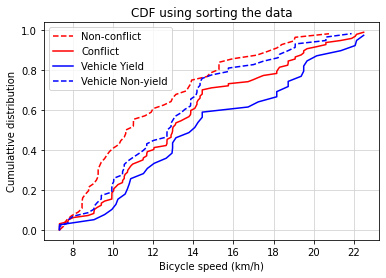

In [652]:
plotCumulativeDistributionBasedOnFeature('MeanSpeed', xLabel='Bicycle speed (km/h)', aboutVehicle=False)

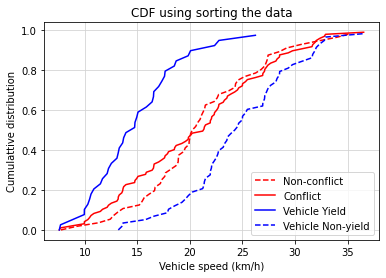

In [653]:
plotCumulativeDistributionBasedOnFeature('MeanSpeed', xLabel='Vehicle speed (km/h)', aboutVehicle=True)

* Seems like for yield events the vehicle mean speed never exceeds ~28 km/h.

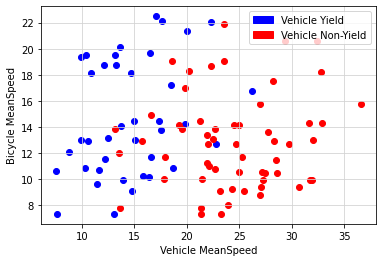

In [654]:
plot = plotYieldAndNonYieldEventsBasedOnFeature(featureName="MeanSpeed")


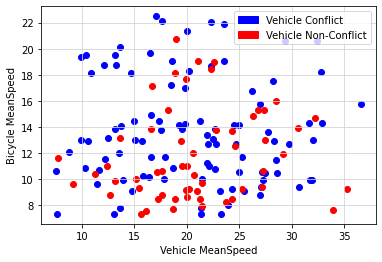

In [655]:
plot = plotConflictAndNonConflictEventsBasedOnFeature(featureName='MeanSpeed')

## Speed At The Border Of Interaction Zone

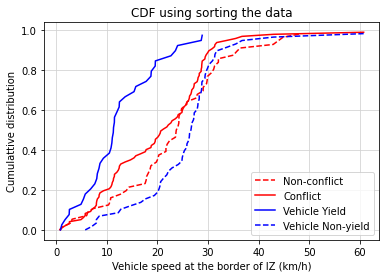

In [656]:
plotCumulativeDistributionBasedOnFeature(featureName='speedAtTheBorderOfInteractionZone', 
                                         xLabel='Vehicle speed at the border of IZ (km/h)', aboutVehicle=True)

* Seems like for yield events the vehicle speed at the border of interaction zone never exceeds 30 km/h.
* For 60% of vehicles who yielded the speed at the border of IZ was less than 15km/h.
* For 60% of vehicles who did not yield the speed at the border of IZ was less than 28km/h.

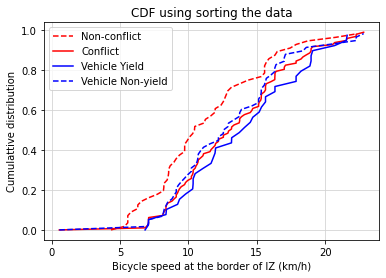

In [657]:
plotCumulativeDistributionBasedOnFeature(featureName='speedAtTheBorderOfInteractionZone', 
                                         xLabel='Bicycle speed at the border of IZ (km/h)', aboutVehicle=False)

* For around 60% of bicycles for who the vehicle yielded the speed at the border of IZ was less than 15km/h.

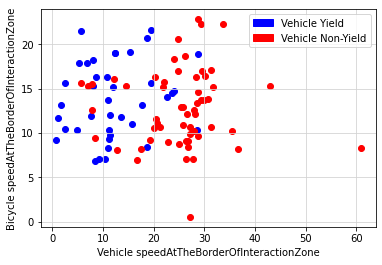

In [658]:
plot = plotYieldAndNonYieldEventsBasedOnFeature(featureName="speedAtTheBorderOfInteractionZone")


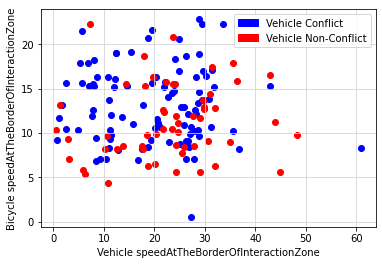

In [659]:
plot = plotConflictAndNonConflictEventsBasedOnFeature(featureName="speedAtTheBorderOfInteractionZone")


## Min speed inside the interaction zone

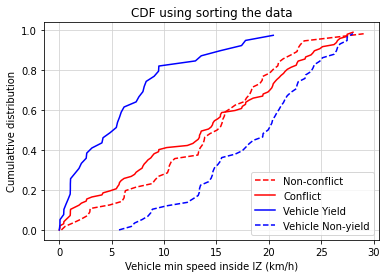

In [660]:
plotCumulativeDistributionBasedOnFeature(featureName='minSpeedInsideInteractionZone', 
                                         xLabel='Vehicle min speed inside IZ (km/h)', aboutVehicle=True)

* For all vehicles who did not yield the minimum speed inside IZ is around 6 km/h so they never stopped inside the IZ.

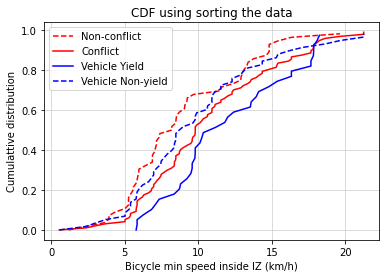

In [661]:
plotCumulativeDistributionBasedOnFeature(featureName='minSpeedInsideInteractionZone', 
                                         xLabel='Bicycle min speed inside IZ (km/h)', aboutVehicle=False)

* For all bicycles for whom the vehicle stopped the minimum speed inside IZ is around 6 km/h so they never stopped inside the IZ.
* 

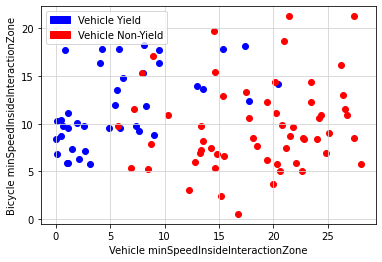

In [662]:
plot = plotYieldAndNonYieldEventsBasedOnFeature(featureName="minSpeedInsideInteractionZone")

* For most of the interactions where vehicle yielded the vehicle min speed inside the IZ was also lower (however the bicycle min speed varied quite a lot).

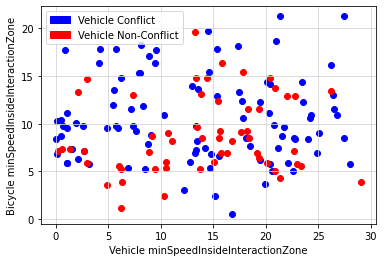

In [663]:
plot = plotConflictAndNonConflictEventsBasedOnFeature(featureName="minSpeedInsideInteractionZone")

## Max speed inside the interaction zone

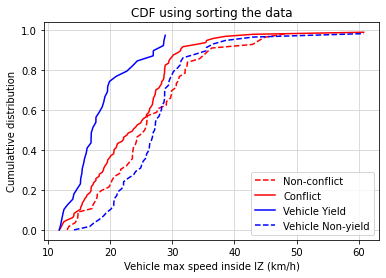

In [664]:
plotCumulativeDistributionBasedOnFeature(featureName='maxSpeedInsideInteractionZone', 
                                         xLabel='Vehicle max speed inside IZ (km/h)', aboutVehicle=True)

* We can see that for yield events the vehicle speed inside the interaction zone is never more than 30 km/h.
* For all vehicles the maximum speed is at least 10 km/h.
* For around 70% of the vehicles who yielded the maximum speed was below 20 km/h.

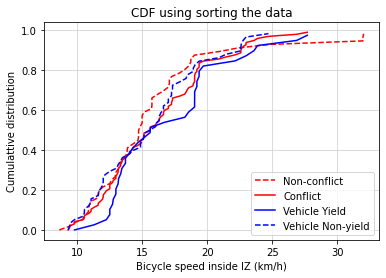

In [665]:
plotCumulativeDistributionBasedOnFeature(featureName='maxSpeedInsideInteractionZone', 
                                         xLabel='Bicycle speed inside IZ (km/h)', aboutVehicle=False)

* For all bicycles 

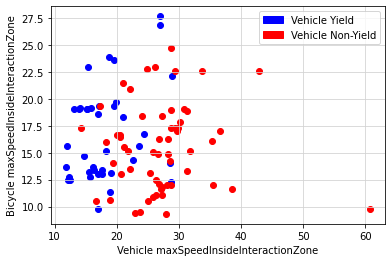

In [666]:
plot = plotYieldAndNonYieldEventsBasedOnFeature(featureName="maxSpeedInsideInteractionZone")

* For most of the interactions where vehicle yielded the vehicle max speed was also lower - the max speed was always  less tham 30 km/h and mainly even less than 25 km/h.

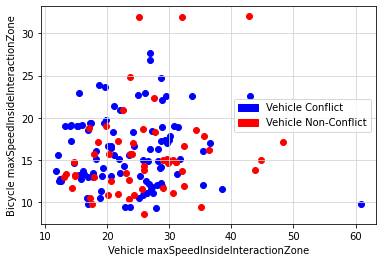

In [667]:
plot = plotConflictAndNonConflictEventsBasedOnFeature(featureName="maxSpeedInsideInteractionZone")

## Absolute Arrival Time Difference

In [668]:
def addAbsoluteArrivalTimeDifference(df):
    df['absoluteArrivalTimeDifference'] = df['arrivalTimeDifference'].apply(lambda x: abs(x)) 
    return df


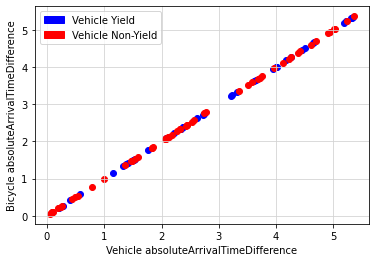

In [669]:
plot = plotYieldAndNonYieldEventsBasedOnFeature(featureName="absoluteArrivalTimeDifference",
                                               dataAdjustingFunction=addAbsoluteArrivalTimeDifference)

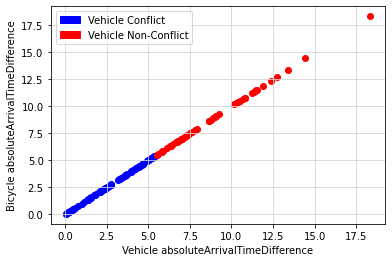

In [670]:
plot = plotConflictAndNonConflictEventsBasedOnFeature(featureName="absoluteArrivalTimeDifference", 
                                                      dataAdjustingFunction=addAbsoluteArrivalTimeDifference)


## Arrival order (based on Arrival Time Difference)

* If vehicle arrived first to the IZ did it mean that it never yielded?
* Negative "arrivalTimeDifference" means that car reached the IZ first.

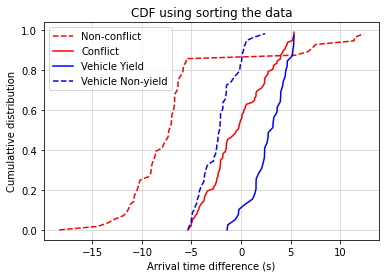

In [671]:
plotCumulativeDistributionBasedOnFeature(featureName='arrivalTimeDifference', 
                                         xLabel='Arrival time difference (s)', aboutVehicle=True)

* For around 90% of the cases when vehicle reached the IZ first then it did not yield.
* If vehicle reached the IZ after the bicycle then on 90% of cases it yielded.

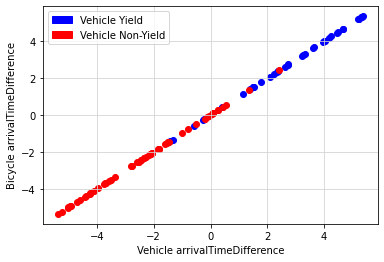

In [672]:
plot = plotYieldAndNonYieldEventsBasedOnFeature(featureName="arrivalTimeDifference")

## Distnace from CZ when first agent of interaction entered IZ

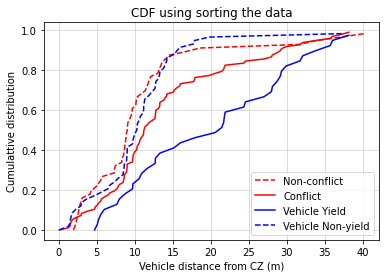

In [715]:
plotCumulativeDistributionBasedOnFeature(featureName='distanceFromCZWhenFirstAgentEnteredIZ', 
                                         xLabel='Vehicle distance from CZ (m)', aboutVehicle=True)

* If vehicle was closer than 5m to the CZ it never yielded.

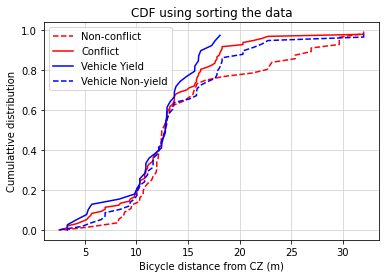

In [716]:
plotCumulativeDistributionBasedOnFeature(featureName='distanceFromCZWhenFirstAgentEnteredIZ', 
                                         xLabel='Bicycle distance from CZ (m)', aboutVehicle=False)

* The maximum bicycle distance from CZ was around 18m for vehicle to yield.
* For around 50% of the cases if bicycle was arounf 12m from CZ then car yielded.

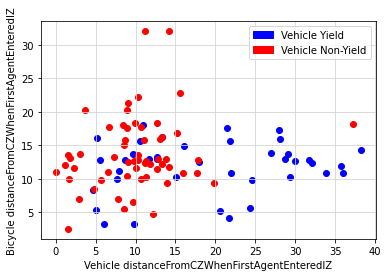

In [717]:
plot = plotYieldAndNonYieldEventsBasedOnFeature(featureName="distanceFromCZWhenFirstAgentEnteredIZ")

* Seems like veicle yielded when bicycle distance from CZ was less than ~18m and vehicle's own distance from CZ was more than 5m.
* Seems like for most of the cases when vehicle did not yield it's distance from CZ was less than 20m (however the bicycles distance was also similar).

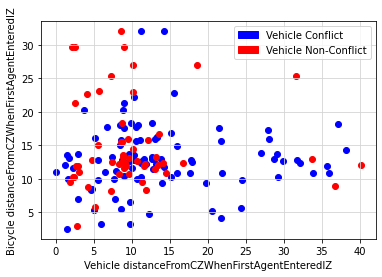

In [718]:
plot = plotConflictAndNonConflictEventsBasedOnFeature(featureName="distanceFromCZWhenFirstAgentEnteredIZ")

* Most conflict events have the bicycle distance from CZ less than 20m independent of the car distance from CZ.

## Distance from IZ together with speed 

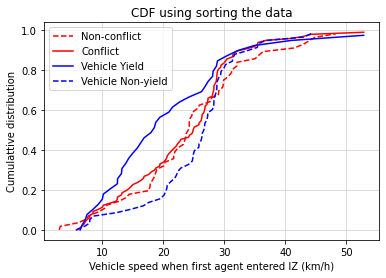

In [725]:
plotCumulativeDistributionBasedOnFeature(featureName='speedWhenFirstAgentEnteredIZ', 
                                         xLabel='Vehicle speed when first agent entered IZ (km/h)', aboutVehicle=True)

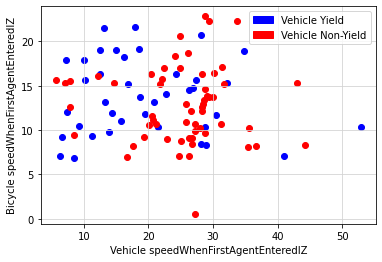

In [726]:
plot = plotYieldAndNonYieldEventsBasedOnFeature(featureName="speedWhenFirstAgentEnteredIZ")

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

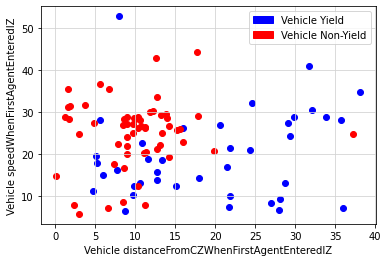

In [734]:
plotYieldAndNonYieldEventsBasedOnTwoFeatures('distanceFromCZWhenFirstAgentEnteredIZ', 'speedWhenFirstAgentEnteredIZ', 
                                             aboutVehicle=True, dataAdjustingFunction=None)

* From here it seems like the distnace from IZ plays a bigger role than speed - because most of the vehicles who yielded where further away however the speed did not vary that much.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

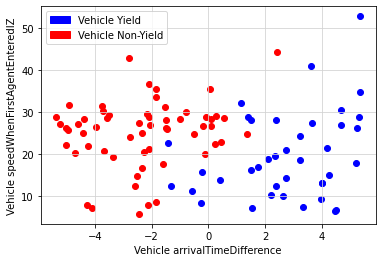

In [738]:
plotYieldAndNonYieldEventsBasedOnTwoFeatures('arrivalTimeDifference', 'speedWhenFirstAgentEnteredIZ', 
                                             aboutVehicle=True, dataAdjustingFunction=None)


* There are only ~5 cases where vehicle entered the IZ first but still yielded. 
* Seems like in these cases the arrival time difference was realy small (bicycle enetered IZ less than 2 seconds later) and also vehicle speed was rather low.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

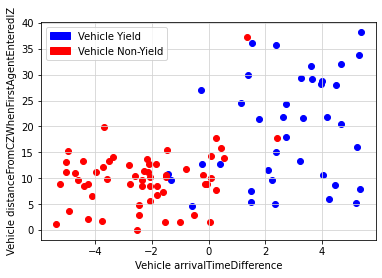

In [737]:
plotYieldAndNonYieldEventsBasedOnTwoFeatures('arrivalTimeDifference', 'distanceFromCZWhenFirstAgentEnteredIZ', 
                                             aboutVehicle=True, dataAdjustingFunction=None)

* This seems to show something about the data itself - so in case of most of the non-yield events the vehicle entered the IZ first and therefore was also closer to the CZ (although they should be around 10m away then which is not the case for all red dots - so shows how inprecise the data is).

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

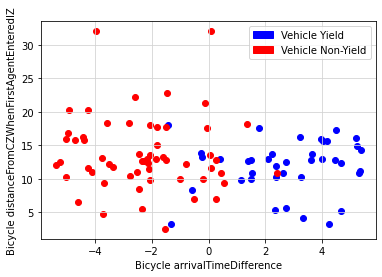

In [739]:
plotYieldAndNonYieldEventsBasedOnTwoFeatures('arrivalTimeDifference', 'distanceFromCZWhenFirstAgentEnteredIZ', 
                                             aboutVehicle=False, dataAdjustingFunction=None)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

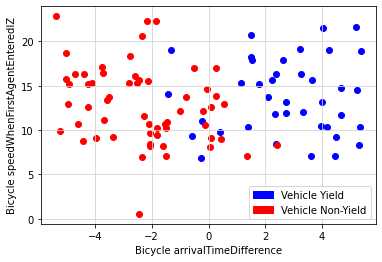

In [740]:
plotYieldAndNonYieldEventsBasedOnTwoFeatures('arrivalTimeDifference', 'speedWhenFirstAgentEnteredIZ', 
                                             aboutVehicle=False, dataAdjustingFunction=None)

## Clustering

* Seems like we can't use arrays as features, so I will remove them: *DateTime*, *Sec*, *Xcoord*, *Ycoord*, *Speed*, *distanceFromConflictZone*.
* Then I will separate the data to test and train. 
* Then let's run some classifiers.

In [674]:
#print(data.get('InteractionID'))

df = pd.read_csv(INTERACTIONS_FILE_NAME, sep=';', converters=CSV_CONVERTERS, dtype='object')

# Array can not be a feature.
# So I will currently discard all the features that include arrays
# = DateTime, Sec, Xcoord, Ycoord, Speed, distanceFromConflictZone

df_without_lists = df.drop(['DateTime', 'Sec', 'Xcoord', 'Ycoord', 'Speed', 'distanceFromConflictZone'], axis=1)
df_without_lists.head()


<ipython-input-674-4360086cf592>:3: ParserWarning: Both a converter and dtype were specified for column DateTime - only the converter will be used
  df = pd.read_csv(INTERACTIONS_FILE_NAME, sep=';', converters=CSV_CONVERTERS, dtype='object')
<ipython-input-674-4360086cf592>:3: ParserWarning: Both a converter and dtype were specified for column Sec - only the converter will be used
  df = pd.read_csv(INTERACTIONS_FILE_NAME, sep=';', converters=CSV_CONVERTERS, dtype='object')
<ipython-input-674-4360086cf592>:3: ParserWarning: Both a converter and dtype were specified for column Xcoord - only the converter will be used
  df = pd.read_csv(INTERACTIONS_FILE_NAME, sep=';', converters=CSV_CONVERTERS, dtype='object')
<ipython-input-674-4360086cf592>:3: ParserWarning: Both a converter and dtype were specified for column Ycoord - only the converter will be used
  df = pd.read_csv(INTERACTIONS_FILE_NAME, sep=';', converters=CSV_CONVERTERS, dtype='object')
<ipython-input-674-4360086cf592>:3: Parse

,InteractionID,CarID,ID,AgentType,timeOfEnteringInteractionZone,speedAtTheBorderOfInteractionZone,minSpeedInsideInteractionZone,maxSpeedInsideInteractionZone,arrivalTimeDifference,yielded
0,0,296,296,2,1504540484.674,23.5712252141,21.3703493929,23.5712252141,12.371000051498413,1
1,0,296,12026,1,1504540472.303,10.4448183378,4.35105236445,10.4448183378,12.371000051498413,0
2,1,304,304,2,1504541916.363,29.0651464759,23.0033522034,29.0651464759,-6.694000005722046,0
3,1,304,3904,1,1504541923.057,11.6473502404,5.76505800618,11.6473502404,-6.694000005722046,1
4,2,386,386,2,1504541382.497,12.2580601627,8.74844893612,18.2106110805,-2.574000120162964,0


In [675]:
X = df_without_lists[df_without_lists.columns[0:-1]].copy()
y = df_without_lists[[df_without_lists.columns[-1]]].copy()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)